# Intro
3D object classification using VoxNet and LIDAR point cloud data (http://www.acfr.usyd.edu.au/papers/SydneyUrbanObjectsDataset.shtml)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
import os

from sklearn.model_selection import train_test_split

from tensorflow import keras
from mpl_toolkits import mplot3d

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import re

%matplotlib inline  

# Load data

In [2]:
def loadFile(fileName):
    names = ['t','intensity','id',
         'x','y','z',
         'azimuth','range','pid']

    formats = ['int64', 'uint8', 'uint8',
           'float32', 'float32', 'float32',
           'float32', 'float32', 'int32']

    binType = np.dtype( dict(names=names, formats=formats) )
    data = np.fromfile(fileName, binType)

    # 3D points, one per row
    P = np.vstack([ data['x'], data['y'], data['z'] ]).T
    
    return P

folderName = 'sydney-urban-objects-dataset/objects'

classes = ['4wd',
    'bench',
    'bicycle',
    'biker',
    'building',
    'bus',
    'car',
    'cyclist',
    'pedestrian',
    'pillar',
    'pole',
    'post',
    'scooter',
    'ticket_machine',
    'traffic_lights',
    'traffic_sign',
    'trailer',
    'trash',
    'tree',
    'truck',
    'trunk',
    'umbrella',
    'ute',
    'van',
    'vegetation']

nClass = len(classes)
print('number of class:', nClass)

number of class: 25


In [3]:
label = []
rawSet = []
for i in range(nClass):
    className = classes[i]
    for fileName in os.listdir(folderName):
        searchStr = className + '.*bin'
        match = re.fullmatch(searchStr, fileName)
        if match:
            fullFileName = folderName + '/' + fileName
            rawSet.append(loadFile(fullFileName))
            label.append(i)
print('number of data:', len(rawSet))

number of data: 630


# Sample data

In [4]:
def draw3D(points):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter3D(points[:,0],points[:,1],points[:,2], c='r')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_zlim(ax.get_zlim()[::-1])
    
def draw2D(points):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(points[:,0],points[:,2])
    ax2.scatter(points[:,1],points[:,2])
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax1.set_xlabel('X')
    ax2.set_xlabel('Y')

def drawVoxel(voxels):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(voxels)
    ax.invert_zaxis()

## Bicycle

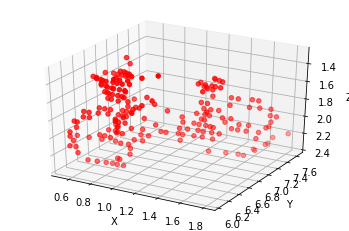

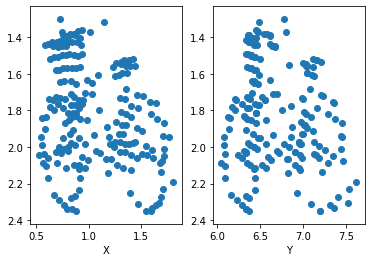

In [5]:
draw3D(rawSet[30])
draw2D(rawSet[30])

## Car

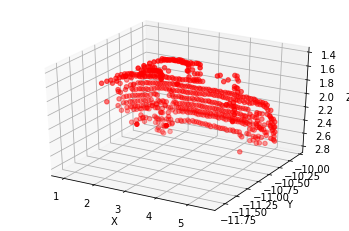

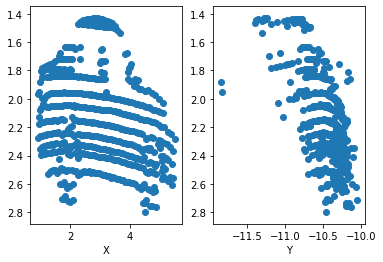

In [6]:
draw3D(rawSet[147])
draw2D(rawSet[147])

## Pedestrian

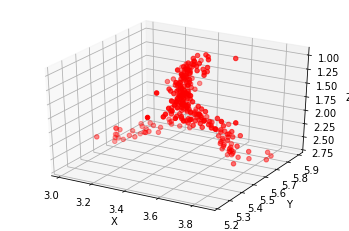

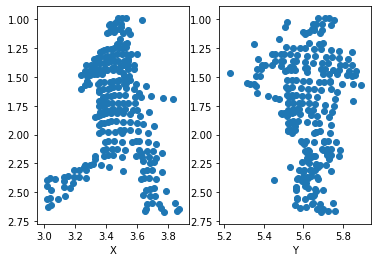

In [7]:
draw3D(rawSet[168])
draw2D(rawSet[168])

## Traffic light

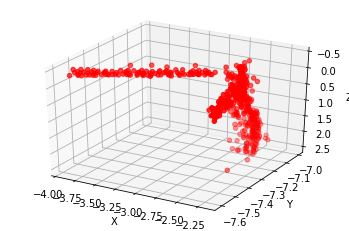

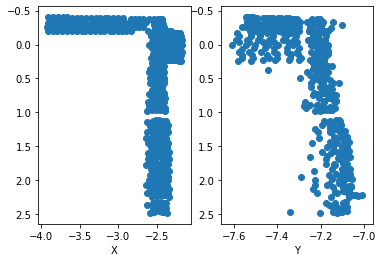

In [8]:
draw3D(rawSet[414])
draw2D(rawSet[414])

## Tree

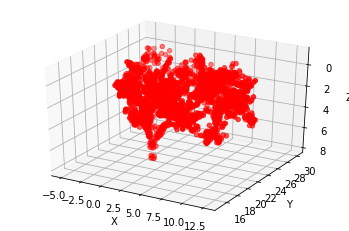

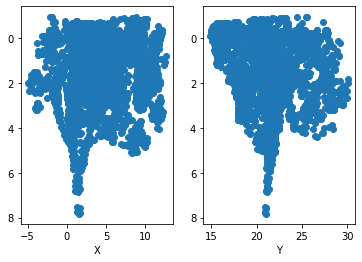

In [9]:
draw3D(rawSet[472])
draw2D(rawSet[472])

## Truck

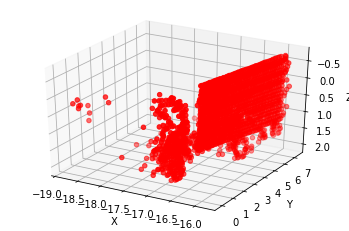

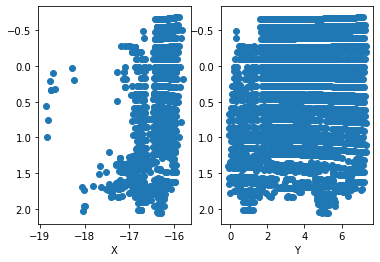

In [10]:
draw3D(rawSet[505])
draw2D(rawSet[505])

# Inbalanced data
There are 631 samples from 26 different classes and the data is very inbalanced

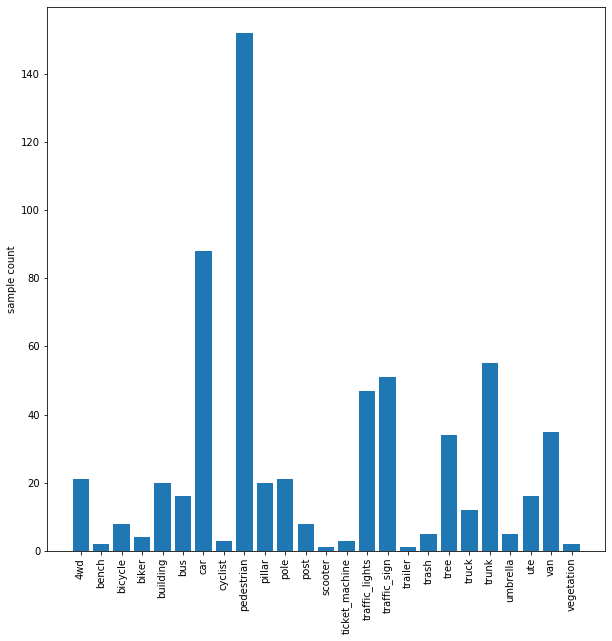

                sample count
4wd                       21
bench                      2
bicycle                    8
biker                      4
building                  20
bus                       16
car                       88
cyclist                    3
pedestrian               152
pillar                    20
pole                      21
post                       8
scooter                    1
ticket_machine             3
traffic_lights            47
traffic_sign              51
trailer                    1
trash                      5
tree                      34
truck                     12
trunk                     55
umbrella                   5
ute                       16
van                       35
vegetation                 2


In [11]:
count, bins = np.histogram(label, bins = nClass, range=(0,nClass))
plt.figure(figsize=(10,10))
plt.bar(range(nClass),count)
plt.xticks(range(nClass), classes, rotation='vertical')
plt.ylabel('sample count')
plt.show()
print(pd.DataFrame(count, classes, ['sample count']))

# Binary classification
Combine 4wd, bus, car, truck, ute, and van into vehicle class, and use pedestrian class.

In [12]:
binarySet = []
binaryLabel = []
for i in range(len(rawSet)):
    l = classes[label[i]]
    if l == '4wd' or l == 'bus' or l == 'car' or l == 'truck' or l == 'ute' or l == 'van':
        binarySet.append(rawSet[i])
        binaryLabel.append(True)
    elif l == 'pedestrian':
        binarySet.append(rawSet[i])
        binaryLabel.append(False)


## Binary classification - shuffle and split data

In [13]:
def transformPts(pts):
    # 1x3 matrices for x,y,z min and max
    lowerBound = np.min(pts,axis=0)
    upperBound = np.max(pts,axis=0)+0.0001
    
    # rescale the range to 0-32
    scale = 32/(upperBound-lowerBound)
    
    # apply transformation
    newPts = (pts-lowerBound)*scale
    
    return newPts

def getFeatVec(pts):
    transPts = transformPts(pts)
    result = np.zeros((32,32,32))
    for pt in transPts:
        idx = np.floor(pt)
        idx = idx.astype(int)
        result[idx[0],idx[1],idx[2]] += 1
    
    return result


In [14]:
binaryPtCloudSetTrain, binaryPtCloudSetTest, binaryLabelTrain, binaryLabelTest = train_test_split(binarySet, binaryLabel, test_size = 0.2)
nTrain = len(binaryPtCloudSetTrain)
nTest = len(binaryPtCloudSetTest)

In [15]:
binaryVoxelSetTrain = np.zeros((nTrain, 32, 32, 32))
binaryVoxelSetTest = np.zeros((nTest, 32, 32, 32))

for i in range(nTrain):
    binaryVoxelSetTrain[i,:,:,:] = getFeatVec(binaryPtCloudSetTrain[i])
for i in range(nTest):
    binaryVoxelSetTest[i,:,:,:] = getFeatVec(binaryPtCloudSetTest[i])
    
# Expand feat vec for CONV3D
x_train = np.expand_dims(binaryVoxelSetTrain, axis = 4)
x_test = np.expand_dims(binaryVoxelSetTest, axis = 4)
y_train = binaryLabelTrain
y_test = binaryLabelTest

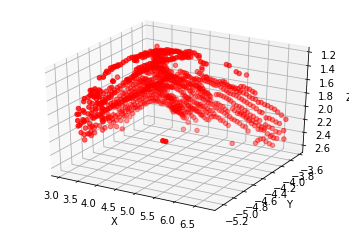

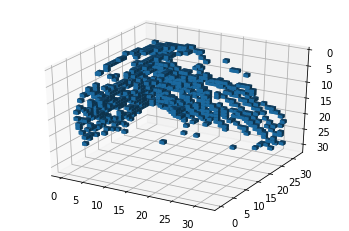

In [16]:
draw3D(binaryPtCloudSetTrain[2])
drawVoxel(binaryVoxelSetTrain[2,:,:,:])

## Binary classification - CNN model

In [17]:
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(5,5,5), input_shape=(32, 32, 32, 1), strides=(2,2,2)))
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(3,3,3)))
cnn_model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(units=128,activation='relu'))
cnn_model.add(keras.layers.Dense(units=1,activation='sigmoid'))
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 14, 14, 14, 2)     252       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 12, 12, 2)     110       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 6, 6, 2)        0         
_________________________________________________________________
flatten (Flatten)            (None, 432)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               55424     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 55,915
Trainable params: 55,915
Non-trainable params: 0


In [18]:
history = cnn_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Train on 272 samples, validate on 68 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
272/272 [==============================] - 2s 7ms/sample - loss: 0.6550 - acc: 0.5478 - val_loss: 0.6064 - val_acc: 0.5882
Epoch 2/5
272/272 [==============================] - 2s 7ms/sample - loss: 0.5626 - acc: 0.5478 - val_loss: 0.5481 - val_acc: 0.6176
Epoch 3/5
272/272 [==============================] - 2s 6ms/sample - loss: 0.4894 - acc: 0.7316 - val_loss: 0.4976 - val_acc: 0.8382
Epoch 4/5
272/272 [==============================] - 1s 5ms/sample - loss: 0.4343 - acc: 0.9118 - val_loss: 0.4515 - val_acc: 0.8529
Epoch 5/5
272/272 [==============================] - 1s 5ms/sample - loss: 0.3746 - acc: 0.9375 - val_loss: 0.4106 - val_acc: 0.8529


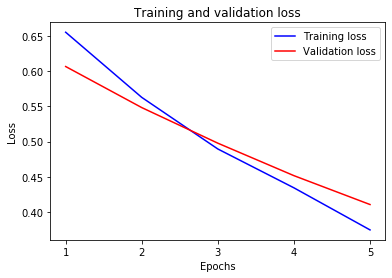

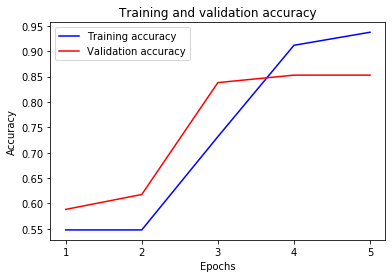

       loss       acc  val_loss   val_acc
0  0.655012  0.547794  0.606386  0.588235
1  0.562591  0.547794  0.548111  0.617647
2  0.489381  0.731618  0.497620  0.838235
3  0.434274  0.911765  0.451545  0.852941
4  0.374573  0.937500  0.410582  0.852941


In [19]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()

print(pd.DataFrame(history_dict))

In [20]:
y_predict_prob = cnn_model.predict(x_test)
y_predict = y_predict_prob > 0.5

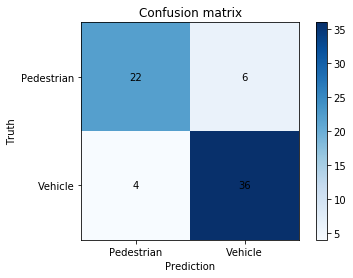

In [21]:
conf_matrix = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots()
ax.set_title('Confusion matrix')
ax.set_yticks([0,1])
ax.set_xticks([0,1])
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set_xticklabels(['Pedestrian','Vehicle'])
ax.set_yticklabels(['Pedestrian','Vehicle'])
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_matrix[i, j],
                ha="center", va="center",
                color="black")

## Binary classification - Prediction results

In [22]:
# Find examples of true pos, true neg, false pos, and false neg
for i in range(len(y_test)):
    if y_test[i] == True and y_predict[i] == True:
        tpIdx = i
        break
for i in range(len(y_test)):
    if y_test[i] == False and y_predict[i] == False:
        tnIdx = i
        break
for i in range(len(y_test)):
    if y_test[i] == False and y_predict[i] == True:
        fpIdx = i
        break
for i in range(len(y_test)):
    if y_test[i] == True and y_predict[i] == False:
        fnIdx = i
        break

## Binary classification - Successful classification - vehicle

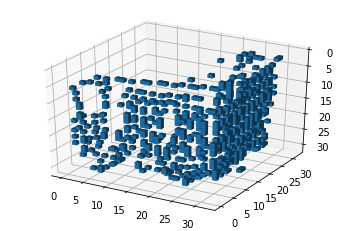

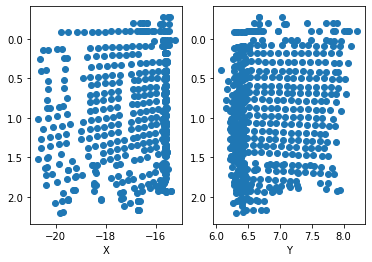

In [23]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(binaryVoxelSetTest[tpIdx])
ax.invert_zaxis()

draw2D(binaryPtCloudSetTest[tpIdx])

## Binary classification - Successful classification - pedestrian 

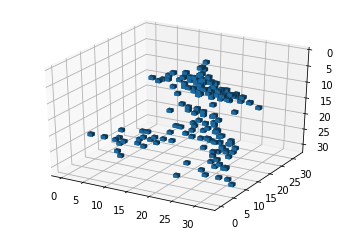

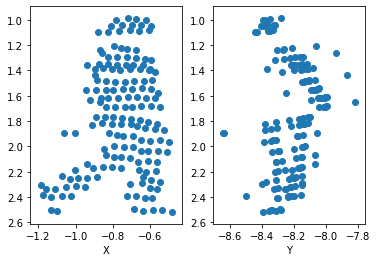

In [24]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(binaryVoxelSetTest[tnIdx])
ax.invert_zaxis()

draw2D(binaryPtCloudSetTest[tnIdx])

## Binary classification - Failed classification - pedestrian calssified as vehicle 

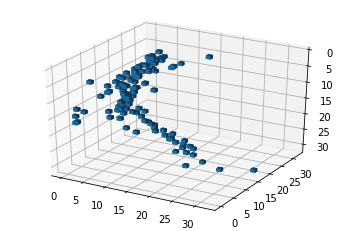

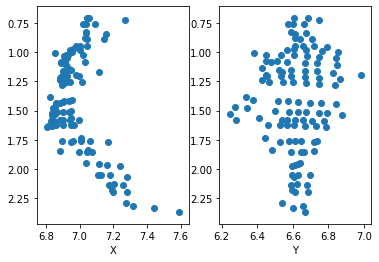

In [25]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(binaryVoxelSetTest[fpIdx])
ax.invert_zaxis()

draw2D(binaryPtCloudSetTest[fpIdx])

## Binary Classification - Failed classification - vehicle calssified as pedestrian 

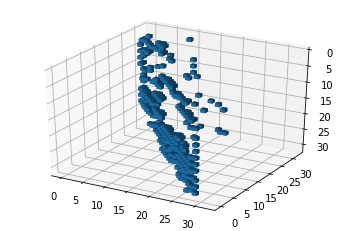

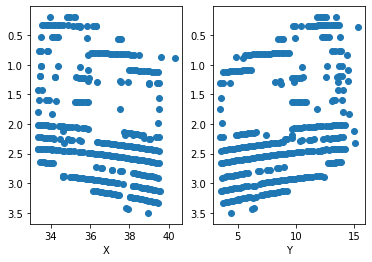

In [26]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(binaryVoxelSetTest[fnIdx])
ax.invert_zaxis()

draw2D(binaryPtCloudSetTest[fnIdx])

# Multi-class classification

In [27]:
supportedClassesDic = {'car':0,'pedestrian':1,'traffic_sign':2,'trunk':3}
supportedClasses = list(supportedClassesDic)


In [28]:
multiSet = []
multiLabel = []
for i in range(len(rawSet)):
    l = classes[label[i]]
    if l in supportedClassesDic:
        multiSet.append(rawSet[i])
        multiLabel.append(supportedClassesDic[l])
        
nMultiClass = len(supportedClasses)

## Multi-class classification - Shuffle and split data

In [29]:
multiPtCloudSetTrain, multiPtCloudSetTest, multiLabelTrain, multiLabelTest = train_test_split(multiSet, multiLabel, test_size = 0.2)
nTrain = len(multiPtCloudSetTrain)
nTest = len(multiPtCloudSetTest)

In [30]:
multiVoxelSetTrain = np.zeros((nTrain, 32, 32, 32))
multiVoxelSetTest = np.zeros((nTest, 32, 32, 32))

for i in range(nTrain):
    multiVoxelSetTrain[i,:,:,:] = getFeatVec(multiPtCloudSetTrain[i])
for i in range(nTest):
    multiVoxelSetTest[i,:,:,:] = getFeatVec(multiPtCloudSetTest[i])
    
# Expand feat vec for CONV3D
x_train = np.expand_dims(multiVoxelSetTrain, axis = 4)
x_test = np.expand_dims(multiVoxelSetTest, axis = 4)

y_train = keras.utils.to_categorical(multiLabelTrain)
y_test = keras.utils.to_categorical(multiLabelTest)

## Multi-class classification - CNN model

In [31]:
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(5,5,5), input_shape=(32, 32, 32, 1), strides=(2,2,2)))
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(3,3,3)))
cnn_model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(units=256,activation='relu'))
cnn_model.add(keras.layers.Dense(units=nMultiClass,activation='softmax'))
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 14, 14, 14, 2)     252       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 12, 12, 12, 2)     110       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 6, 6, 2)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               110848    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 112,238
Trainable params: 112,238
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = cnn_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Train on 276 samples, validate on 70 samples
Epoch 1/10
276/276 [==============================] - 2s 6ms/sample - loss: 1.3091 - acc: 0.4529 - val_loss: 1.1926 - val_acc: 0.5857
Epoch 2/10
276/276 [==============================] - 1s 5ms/sample - loss: 1.1355 - acc: 0.6304 - val_loss: 1.1210 - val_acc: 0.6286
Epoch 3/10
276/276 [==============================] - 1s 5ms/sample - loss: 1.0196 - acc: 0.6739 - val_loss: 1.0802 - val_acc: 0.6429
Epoch 4/10
276/276 [==============================] - 2s 6ms/sample - loss: 0.9321 - acc: 0.7355 - val_loss: 1.0646 - val_acc: 0.7000
Epoch 5/10
276/276 [==============================] - 2s 6ms/sample - loss: 0.8591 - acc: 0.7790 - val_loss: 1.0420 - val_acc: 0.6571
Epoch 6/10
276/276 [==============================] - 1s 5ms/sample - loss: 0.7917 - acc: 0.7826 - val_loss: 1.0035 - val_acc: 0.6429
Epoch 7/10
276/276 [==============================] - 2s 6ms/sample - loss: 0.7106 - acc: 0.7971 - val_loss: 0.9538 - val_acc: 0.6429
Epoch 8/10
276/27

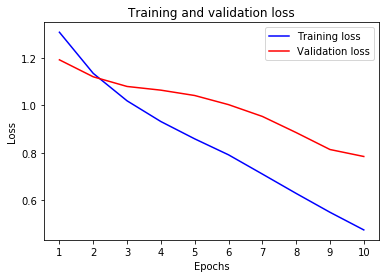

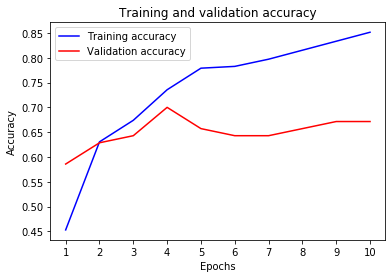

       loss       acc  val_loss   val_acc
0  1.309073  0.452899  1.192647  0.585714
1  1.135480  0.630435  1.120990  0.628571
2  1.019610  0.673913  1.080198  0.642857
3  0.932109  0.735507  1.064606  0.700000
4  0.859069  0.778986  1.042020  0.657143
5  0.791675  0.782609  1.003503  0.642857
6  0.710563  0.797101  0.953758  0.642857
7  0.628746  0.815217  0.885567  0.657143
8  0.549113  0.833333  0.814039  0.671429
9  0.474646  0.851449  0.784609  0.671429


In [33]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()

print(pd.DataFrame(history_dict))

## Multi-class classification - confusion matrix

In [34]:
y_predict_prob = cnn_model.predict(x_test)
y_predict = np.argmax(y_predict_prob,axis=1)

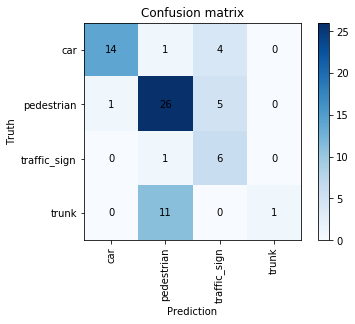

In [35]:
conf_matrix = confusion_matrix(multiLabelTest, y_predict)
fig, ax = plt.subplots()
ax.set_title('Confusion matrix')
ax.set_yticks(range(nMultiClass))
ax.set_xticks(range(nMultiClass))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set_xticklabels(supportedClasses, rotation='vertical')
ax.set_yticklabels(supportedClasses)
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")
for i in range(nMultiClass):
    for j in range(nMultiClass):
        ax.text(j, i, conf_matrix[i, j],
                ha="center", va="center",
                color="black")

In [36]:
acc = []
for i in range(nMultiClass):
    c = conf_matrix[i,i]
    s = np.sum(conf_matrix[i,:])
    acc.append(c/s)
pd.DataFrame(acc, supportedClasses, ['Accuracy'])

,Accuracy
car,0.736842
pedestrian,0.812500
traffic_sign,0.857143
trunk,0.083333


# Classification with 25 classes

In [43]:
ptCloudSetTrain, ptCloudSetTest, labelTrain, labelTest = train_test_split(rawSet, label, test_size = 0.2)
nTrain = len(ptCloudSetTrain)
nTest = len(ptCloudSetTest)

In [44]:
voxelSetTrain = np.zeros((nTrain, 32, 32, 32))
voxelSetTest = np.zeros((nTest, 32, 32, 32))

for i in range(nTrain):
    voxelSetTrain[i,:,:,:] = getFeatVec(ptCloudSetTrain[i])
for i in range(nTest):
    voxelSetTest[i,:,:,:] = getFeatVec(ptCloudSetTest[i])
    
# Expand feat vec for CONV3D
x_train = np.expand_dims(voxelSetTrain, axis = 4)
x_test = np.expand_dims(voxelSetTest, axis = 4)

y_train = keras.utils.to_categorical(labelTrain)
y_test = keras.utils.to_categorical(labelTest)

## CNN model

### Use f1 score instead of accuracy for each epoch

In [45]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [46]:
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(5,5,5), input_shape=(32, 32, 32, 1), strides=(2,2,2)))
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(3,3,3)))
cnn_model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(units=256,activation='relu'))
cnn_model.add(keras.layers.Dense(units=nClass,activation='softmax'))
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [f1_m])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 14, 14, 14, 2)     252       
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 12, 12, 12, 2)     110       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 6, 6, 6, 2)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               110848    
_________________________________________________________________
dense_7 (Dense)              (None, 25)                6425      
Total params: 117,635
Trainable params: 117,635
Non-trainable params: 0
_________________________________________________________________


### Adjust loss function based on class instance nubmers 

In [47]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labelTrain),
                                                 labelTrain)

In [48]:
history = cnn_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), class_weight=class_weights)

Train on 504 samples, validate on 126 samples
Epoch 1/10
504/504 [==============================] - 3s 6ms/sample - loss: 3.1278 - f1_m: 0.0000e+00 - val_loss: 2.8922 - val_f1_m: 0.0000e+00
Epoch 2/10
504/504 [==============================] - 2s 5ms/sample - loss: 2.7417 - f1_m: 0.0120 - val_loss: 2.6275 - val_f1_m: 0.0149
Epoch 3/10
504/504 [==============================] - 3s 5ms/sample - loss: 2.4681 - f1_m: 0.0382 - val_loss: 2.5057 - val_f1_m: 0.0602
Epoch 4/10
504/504 [==============================] - 3s 5ms/sample - loss: 2.2302 - f1_m: 0.0751 - val_loss: 2.3583 - val_f1_m: 0.1168
Epoch 5/10
504/504 [==============================] - 3s 6ms/sample - loss: 2.0009 - f1_m: 0.1626 - val_loss: 2.2476 - val_f1_m: 0.1879
Epoch 6/10
504/504 [==============================] - 3s 5ms/sample - loss: 1.8157 - f1_m: 0.2919 - val_loss: 2.1239 - val_f1_m: 0.2681
Epoch 7/10
504/504 [==============================] - 3s 5ms/sample - loss: 1.6539 - f1_m: 0.3498 - val_loss: 2.1971 - val_f1_m: 0

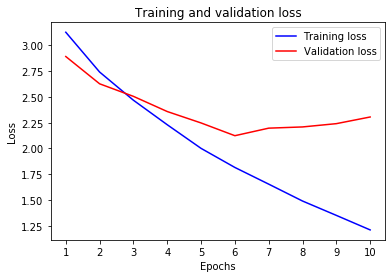

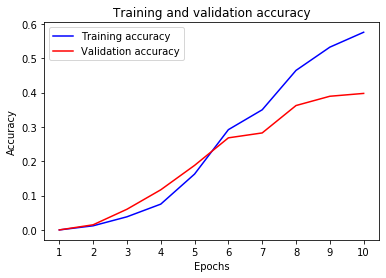

       loss      f1_m  val_loss  val_f1_m
0  3.127794  0.000000  2.892210  0.000000
1  2.741724  0.012003  2.627513  0.014925
2  2.468056  0.038192  2.505704  0.060161
3  2.230241  0.075081  2.358341  0.116795
4  2.000905  0.162633  2.247628  0.187928
5  1.815738  0.291946  2.123905  0.268148
6  1.653866  0.349824  2.197099  0.282445
7  1.489994  0.464555  2.208903  0.362221
8  1.350703  0.532236  2.240778  0.389237
9  1.209653  0.575661  2.305480  0.397533


In [49]:
history_dict = history.history

acc = history_dict['f1_m']
val_acc = history_dict['val_f1_m']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()

print(pd.DataFrame(history_dict))

## Confusion matrix

In [50]:
y_predict_prob = cnn_model.predict(x_test)
y_predict = np.argmax(y_predict_prob,axis=1)

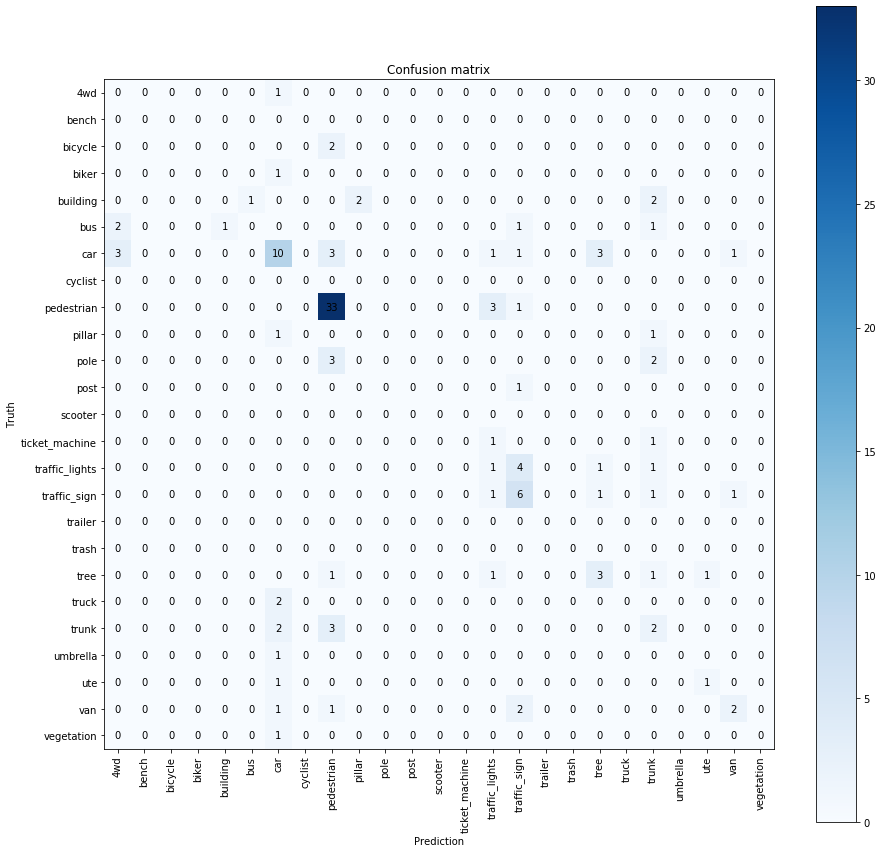

In [51]:
conf_matrix = confusion_matrix(labelTest, y_predict,range(nClass))
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Confusion matrix')
ax.set_yticks(range(nClass))
ax.set_xticks(range(nClass))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set_xticklabels(classes, rotation='vertical')
ax.set_yticklabels(classes)
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")
for i in range(nClass):
    for j in range(nClass):
        ax.text(j, i, conf_matrix[i, j],
                ha="center", va="center",
                color="black")

In [52]:
acc = []
for i in range(nClass):
    c = conf_matrix[i,i]
    s = np.sum(conf_matrix[i,:])
    if s != 0:
        acc.append(c/s)
    else:
        acc.append('NaN')
pd.DataFrame(acc, classes, ['Accuracy'])

,Accuracy
4wd,0
bench,NaN
bicycle,0
biker,0
building,0
bus,0
car,0.454545
cyclist,NaN
pedestrian,0.891892
pillar,0
